In [1]:
import math
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

assert pyro.__version__.startswith('0.4')
pyro.enable_validation(True)  # can help with debugging
pyro.set_rng_seed(1)

# defining objective function

In [2]:
const_a = 1.0
const_b = 5.1 / (4.0 * math.pow(math.pi, 2))
const_c = 5.0 / math.pi
const_r = 6.0
const_s = 10
const_t = 1.0 / (8.0 * math.pi)

def branin_hoo_first_term(X):
    
    fx = const_s * (1.0 - const_t) * torch.cos(X[0]) + const_s
    
    return fx

def branin_hoo(X):
    
    fx = branin_hoo_first_term(X) + \
        const_a * torch.pow(X[1] - const_b * torch.pow(X[0], 2) + const_c * X[0] - const_r, 2)
    
    return fx

In [3]:
const_x1_min = -5
const_x1_max = 10

X1 = torch.linspace(const_x1_min, const_x1_max, 500)

const_x2_min = 0
const_x2_max = 15

X2 = torch.linspace(const_x2_min, const_x2_max, 500)

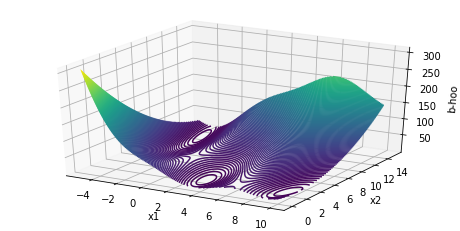

In [4]:
# Plot f(x)

plt.figure(figsize=(8, 4))

ax = plt.axes(projection='3d')

X1_mesh, X2_mesh = torch.meshgrid(X1, X2)

Z_mesh = branin_hoo(torch.stack((X1_mesh, X2_mesh)))

ax = plt.axes(projection='3d')
ax.contour3D(X1_mesh, X2_mesh, Z_mesh, 200)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('b-hoo')

plt.show()

# initialize the model with four input points

In [5]:
X1_train = torch.tensor([0.0, 4.0, 8.0, 12.0])
X2_train = torch.tensor([-5.0, -1.0, 3.0, 7.0])

X_train = torch.stack((X1_train, X2_train))
Y_train = branin_hoo(X_train)

In [6]:
gpmodel = gp.models.GPRegression(X_train.T, Y_train, 
                                 gp.kernels.Matern52(input_dim=2), 
                                 noise=torch.tensor(0.1), 
                                 jitter=1.0e-4)

In [7]:
def update_posterior(x_new):
    
    y = branin_hoo(x_new.T) # evaluate f at new point.
    
    X = torch.cat([gpmodel.X, x_new]) # incorporate new evaluation
    y = torch.cat([gpmodel.y, y])
    
    gpmodel.set_data(X, y)
    
    # optimize the GP hyperparameters using Adam with lr=0.001
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    
    gp.util.train(gpmodel, optimizer)

In [8]:
def lower_confidence_bound(x, kappa=2):
    
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

In [9]:
def find_a_candidate(x_init):
    
    # transform x to an unconstrained domain
    constraint_x1 = constraints.interval(const_x1_min, const_x1_max)
    constraint_x2 = constraints.interval(const_x2_min, const_x2_max)

    unconstrained_x1_init = transform_to(constraint_x1).inv(x_init[:, 0])
    unconstrained_x2_init = transform_to(constraint_x2).inv(x_init[:, 1])

    unconstrained_x_init = torch.stack((unconstrained_x1_init, unconstrained_x2_init), dim=1)
    
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    
    minimizer = optim.LBFGS([unconstrained_x])

    def closure():
        minimizer.zero_grad()
                
        x1_tmp = transform_to(constraint_x1)(unconstrained_x[:, 0])
        x2_tmp = transform_to(constraint_x2)(unconstrained_x[:, 1])
        
        y = lower_confidence_bound(torch.stack((x1_tmp, x2_tmp), dim=1))
        
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        
        return y

    minimizer.step(closure)
   
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    
    x1_tmp = transform_to(constraint_x1)(unconstrained_x[:, 0])
    x2_tmp = transform_to(constraint_x2)(unconstrained_x[:, 1])
    
    x = torch.stack((x1_tmp, x2_tmp), dim=1)
        
    return x.detach()

In [10]:
def next_x(num_candidates=5):
    
    candidates = []
    values = []

    x_init = gpmodel.X[-1:]
    
    for i in range(num_candidates):
                
        x = find_a_candidate(x_init)
        
        y = lower_confidence_bound(x)
        
        candidates.append(x)
        
        values.append(y)
        
        x_init = torch.stack(
                (x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                 x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    
    return candidates[argmin]

In [ ]:
def plot(gs, xmin, xlabel=None, with_title=True):
    
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1)
    
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_title("Find {}".format(xlabel))
    
    if with_title:
        ax1.set_ylabel("Gaussian Process Regression")

    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        # plot the acquisition function
        ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))
    
    ax2.set_xlim(-0.1, 1.1)
    
    if with_title:
        ax2.set_ylabel("Acquisition Function")
    ax2.legend(loc=1)
    

In [11]:
plt.figure(figsize=(12, 30))
outer_gs = gridspec.GridSpec(5, 2)
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)

for i in range(8):
    
    xmin = next_x()
        
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
    
    plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))
    
    update_posterior(xmin)
    
plt.show()

tensor([[-4.9685, 14.9786]])
tensor([[0.3507, 7.7147]])
tensor([[ 7.5595, 15.0000]])
tensor([[1.0000e+01, 8.0619e-06]])
tensor([[-5.0000,  4.5710]])
tensor([[5.0583, 1.7030]])
tensor([[6.9230e+00, 3.5414e-05]])
tensor([[4.6351, 6.0058]])
